In [1]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Preprocessing

In [3]:
df = pd.read_csv("results.csv")
columns = {"Sort Function": "Parallel Quicksort", "Parallel": "Bucket Parallel"}
df.rename(columns=columns, inplace=True)
values = {"quicksort": 0, "quicksortparallel": 1}
df["Parallel Quicksort"].replace(values, inplace=True)
df.loc[df["Parallel Quicksort"]==0, "Cutoff"] = "Any"
df.loc[(df["Parallel Quicksort"]==0) & (df["Bucket Parallel"]==0), "Thread Count"] = "Any"

In [4]:
df

,Total Size,Number of Buckets,Thread Count,Parallel,Sort Function,Cutoff,I,CC,Texe,CPI
0,1000,10,1,1,quicksort,1,1.319060e+05,1.474280e+05,45.0,1.117675
1,1000,10,1,1,quicksort,1,1.310380e+05,1.152390e+05,29.0,0.879432
2,1000,10,1,1,quicksort,1,1.311700e+05,1.130680e+05,28.0,0.861996
3,1000,10,1,1,quicksort,1,1.339900e+05,1.123590e+05,28.0,0.838563
4,1000,10,1,1,quicksort,1,1.323370e+05,1.126420e+05,29.0,0.851175
...,...,...,...,...,...,...,...,...,...,...
414195,10000000,100000,12,0,quicksortparallel,10000,1.487897e+09,3.459795e+09,1111800.0,2.325292
414196,10000000,100000,12,0,quicksortparallel,10000,1.488115e+09,3.313714e+09,1076224.0,2.226786
414197,10000000,100000,12,0,quicksortparallel,10000,1.487574e+09,3.388244e+09,1094238.0,2.277698
414198,10000000,100000,12,0,quicksortparallel,10000,1.487755e+09,3.369585e+09,1089419.0,2.264879


# Plotting

In [162]:
def get_means_stds(x, y, num_runs=200):
    assert len(y) % num_runs == 0, print("Number of runs is incorrect")
    
    new_x, y_means, y_stds = [], [], []
    for i in range(int(len(y)/num_runs)):
        new_x.append(x[num_runs*i])
        y_means.append(y[num_runs*i:num_runs*(i+1)].mean())
        y_stds.append(y[num_runs*i:num_runs*(i+1)].std())
    
    new_x = np.array(new_x)
    y_means = np.array(y_means)
    y_stds = np.array(y_stds)
    
    return new_x, y_means, y_stds

def plot(x, y_mean, y_std, cf, label):
    plt.plot(x, y_mean, label=label)
    plt.fill_between(x, y_mean - cf * y_std, y_mean + cf * y_std, alpha=0.2)
    
def Max(x):
    if x.size > 0:
        r = max(x)
    else:
        r = float("-inf")
    return r

def Min(x):
    if x.size > 0:
        r = min(x)
    else:
        r = float("Inf")
    return r

def plot_df_slice (df, x, y, filter_dict, num_runs=200, conf_interval=5, num_ticks=10, yscale="linear", xscale="linear"):
    # Filter dataframe copy
    title = ""
    df_cpy = df
    for key in filter_dict:
        if key in ["Cutoff", "Thread Count"]:
            df_cpy.loc[df_cpy[key] == "Any", key] = filter_dict[key]
        title += f"{key}={filter_dict[key]} "
        df_cpy = df_cpy[df_cpy[key] == filter_dict[key]]
    title += "\n"
    
    # Get Parallel Quicksort Parallel x and y data
    x_pp = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Parallel Quicksort"]==1)][x].to_numpy()
    y_pp = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Parallel Quicksort"]==1)][y].to_numpy()
    x_pp, y_pp_mean, y_pp_std = get_means_stds(x_pp, y_pp, num_runs)
    
    # Get Parallel Quicksort x and y data
    x_ps = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Parallel Quicksort"]==0)][x].to_numpy()
    y_ps = df_cpy[(df_cpy["Bucket Parallel"]==1) & (df_cpy["Parallel Quicksort"]==0)][y].to_numpy()
    x_ps, y_ps_mean, y_ps_std = get_means_stds(x_ps, y_ps, num_runs)
    
    # Get Quicksort Parallel x and y data
    x_sp = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Parallel Quicksort"]==1)][x].to_numpy()
    y_sp = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Parallel Quicksort"]==1)][y].to_numpy()
    x_sp, y_sp_mean, y_sp_std = get_means_stds(x_sp, y_sp, num_runs)
    
    # Get Quicksort x and y data
    x_ss = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Parallel Quicksort"]==0)][x].to_numpy()
    y_ss = df_cpy[(df_cpy["Bucket Parallel"]==0) & (df_cpy["Parallel Quicksort"]==0)][y].to_numpy()
    x_ss, y_ss_mean, y_ss_std = get_means_stds(x_ss, y_ss, num_runs)
    
    # Plot with seaborn
    if len(x_pp) > 0: plot(x_pp, y_pp_mean, y_pp_std, conf_interval, label="PBPQ")
    if len(x_ps) > 0 and x!="Cutoff": plot(x_ps, y_ps_mean, y_ps_std, conf_interval, label="PBSQ")
    if len(x_sp) > 0: plot(x_sp, y_sp_mean, y_sp_std, conf_interval, label="SBPQ")
    if len(x_ss) > 0 and (x!="Thread Count" and x!="Cutoff"): plot(x_ss, y_ss_mean, y_ss_std, conf_interval, label="SBSQ")
    
    # Additional plot settings
    # x_max = max(Max(x_pp), Max(x_ps), Max(x_sp), Max(x_ss))
    # x_min = min(Min(x_pp), Min(x_ps), Min(x_sp), Min(x_ss))
    # y_max = max(Max(y_pp_mean + conf_interval * y_pp_std), Max(y_ps_mean + conf_interval * y_ps_std), Max(y_sp_mean + conf_interval * y_sp_std), Max(y_ss_mean + conf_interval * y_ss_std))
    # y_min = min(Min(y_pp_mean - conf_interval * y_pp_std), Min(y_ps_mean - conf_interval * y_ps_std), Min(y_sp_mean - conf_interval * y_sp_std), Min(y_ss_mean - conf_interval * y_ss_std))
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    # plt.xticks([x_min + i*(x_max-x_min)/num_ticks for i in range(num_ticks)])
    # plt.yticks([y_min + i*(y_max-y_min)/num_ticks for i in range(num_ticks)])
    plt.yscale(yscale)
    plt.xscale(xscale)
    plt.grid(True)
    plt.legend()
    plt.show()

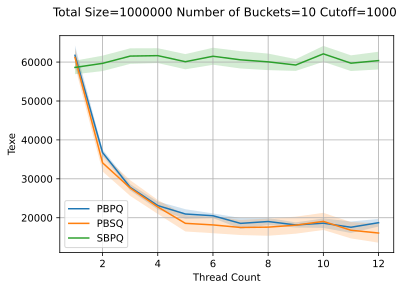

In [171]:
filter_dict = {
    "Total Size": 1000000,
    "Number of Buckets": 10,
    "Cutoff": 1000
}

plot_df_slice(df, x="Thread Count", y="Texe", filter_dict=filter_dict, conf_interval=1, num_ticks=5, yscale="linear", xscale="linear")